In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import pickle
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler

from src.data.data_fetcher import get_all_features, get_raw_data
from src.features.feature_engineering import prepare_data
from src.features.preprocess_data import get_preprocessed_test_data, fetch_preprocessed_data
pd.set_option('display.max_columns', 200)


from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings('ignore')


%pip install xgboost

You should consider upgrading via the 'c:\Users\gunna\Documents\Maskinlæring\Prosjekt\power-predictor\venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [2]:
train_a, train_b, train_c, X_train_estimated_a, X_train_estimated_b, X_train_estimated_c, X_train_observed_a, X_train_observed_b, X_train_observed_c, X_test_estimated_a, X_test_estimated_b, X_test_estimated_c = get_raw_data()

X_train_obs_combined, X_val_obs_combined, y_train_obs_combined, y_val_obs_combined, X_train_est_combined, X_val_est_combined, y_train_est_combined, y_val_est_combined = fetch_preprocessed_data()
x_test_whole = get_preprocessed_test_data()

x_whole = pd.concat([X_train_obs_combined, X_val_obs_combined, X_train_est_combined, X_val_est_combined])
y_whole = pd.concat([y_train_obs_combined, y_val_obs_combined, y_train_est_combined, y_val_est_combined])
x_whole.reset_index(drop=True, inplace=True)
y_whole.reset_index(drop=True, inplace=True)

x_whole.head(10)

X_test_estimated_a.shape = (2880, 47), X_test_estimated_b.shape = (2880, 47), X_test_estimated_c.shape = (2880, 47)
After temporal alignment
X_test_estimated_a.shape = (720, 47), X_test_estimated_b.shape = (720, 47), X_test_estimated_c.shape = (720, 47)
X_test_estimated_a_processed.shape = (720, 46), X_test_estimated_b_processed.shape = (720, 46), X_test_estimated_c_processed.shape = (720, 46)


,absolute_humidity_2m:gm3,air_density_2m:kgm3,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,direct_rad_1h:J,effective_cloud_cover:p,is_day:idx,is_in_shadow:idx,precip_5min:mm,precip_type_5min:idx,pressure_50m:hPa,prob_rime:p,rain_water:kgm2,relative_humidity_1000hPa:p,sun_azimuth:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,location_a,location_b,location_c,sin_day_of_year,cos_day_of_year,sin_hour,cos_hour,sun_product,modified_solar_elevation,effective_radiation,time_since_prediction,cloud_ratio,cloud_cover_over_30%,sun_addition,is_freezing,is_snow,is_rain
0,4.675,1.23925,0.000000e+00,0.000000,2067.925049,0.0,272.924988,0.000000,0.000000e+00,0.000000,0.000000,91.949997,0.0,1.0,0.0,0.0,981.574951,0.00,0.0,65.949997,252.160492,0.00,279.774994,98.974998,45661.750000,3.800,1.100,3.625,0.0,1,0,0,-0.638384,0.769718,-0.866025,-0.500000,0.000000,0.000000,0.000000,0.0,0.929022,1,0.000000,0,0,0
1,4.400,1.23625,4.938225e+04,20.875000,1698.875000,0.0,271.975006,19.175001,4.315202e+04,2.250000,4051.275146,73.699997,1.0,0.0,0.0,0.0,976.950012,0.00,0.0,70.324997,168.481506,0.00,278.000000,93.649994,54169.699219,3.850,-3.775,0.600,0.0,0,1,0,-0.308812,0.951123,0.500000,-0.866025,43.143753,0.048057,0.082039,0.0,0.786973,1,21.425001,0,0,0
2,11.350,1.21775,9.830708e+04,58.775002,124.950005,0.0,286.299988,32.450001,6.597573e+04,1.000000,1871.175049,86.474998,1.0,0.0,0.0,0.0,1005.925049,0.00,0.0,90.275002,69.381248,0.00,287.549988,99.900002,33840.726562,1.825,1.600,0.825,0.0,0,1,0,-0.653160,-0.757220,0.866025,0.500000,32.450001,0.108581,0.019034,0.0,0.865616,1,33.450001,0,0,0
3,4.150,1.30050,0.000000e+00,0.000000,5375.950195,0.0,271.125000,0.000000,0.000000e+00,0.000000,0.000000,64.849998,0.0,1.0,0.0,0.0,1012.450012,0.00,0.0,78.275002,15.757500,0.00,273.549988,95.625000,28736.724609,1.950,-0.550,1.850,0.0,1,0,0,0.855075,-0.518505,0.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.678170,1,0.000000,0,0,0
4,4.300,1.25400,1.162696e+06,378.500000,1466.699951,0.0,271.675018,87.324997,2.866779e+05,278.799988,848206.062500,24.150000,1.0,0.0,0.0,0.0,1003.000000,0.00,0.0,52.099998,130.110260,0.00,278.500000,48.250000,42909.300781,1.000,-0.775,0.675,0.0,0,1,0,0.999930,-0.011826,0.866025,-0.500000,24346.208984,0.394620,0.729517,0.0,0.500518,0,366.125000,0,0,0
5,3.300,1.28150,0.000000e+00,0.000000,5130.399902,0.0,268.299988,0.000000,0.000000e+00,0.000000,0.000000,67.300003,0.0,1.0,0.0,0.0,1014.625000,0.00,0.0,34.799999,178.781754,0.00,278.825012,100.000000,52728.726562,2.100,-1.500,1.450,0.0,0,1,0,0.939570,0.342357,-0.258819,0.965926,0.000000,0.000000,0.000000,0.0,0.673000,1,0.000000,0,0,0
6,6.300,1.24800,0.000000e+00,0.000000,131.375000,0.0,277.100006,0.000000,0.000000e+00,0.000000,0.000000,99.574997,0.0,1.0,0.0,0.0,992.949951,0.00,0.0,93.650002,127.701752,0.35,278.100006,99.974998,3399.375000,6.000,5.950,-0.500,0.0,1,0,0,-0.141444,0.989946,0.965926,-0.258819,0.000000,0.000000,0.000000,0.0,0.995999,1,0.000000,0,0,0
7,3.375,1.26825,0.000000e+00,0.000000,1408.900024,0.0,268.250000,0.000000,0.000000e+00,0.000000,0.000000,96.000000,0.0,1.0,0.0,0.0,994.750000,0.00,0.0,57.849998,326.322754,0.00,276.174988,99.900002,47664.925781,3.775,-0.225,3.775,0.0,0,0,1,0.960885,0.276946,-0.707107,0.707107,0.000000,0.000000,0.000000,0.0,0.960961,1,0.000000,0,1,0
8,6.450,1.18750,2.790292e+06,743.599976,5327.975098,0.0,278.149994,289.200012,1.069732e+06,121.500000,470671.812500,65.824997,1.0,0.0,0.0,0.0,993.200012,0.00,0.0,35.825001,222.466492,0.00,292.149994,96.400002,55477.648438,2.800,-2.500,1.300,0.0,0,1,0,0.457531,-0.889193,-0.258819,-0.965926,35137.800781,0.692024,0.168682,0.0,0.682832,1,410.700012,0,0,0
9,5.500,1.27700,0.000000e+00,0.000000,1367.500000,1.0,275.100006,0.000000,0.000000e+00,0.000000,0.000000,87.175003,0.0,1.0,0.0,0.0,1008.150024,1.15,0.0,90.300003,23.623001,0.10,27

## Train K folds

In [5]:
# K-fold cross validation

num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

total_mae = 0

reg_models = []


for train_index, test_index in kf.split(x_whole):

    reg = xgb.XGBRegressor(n_estimators=1000000,
                       early_stopping_rounds=50,
                       learning_rate= 0.001,
                       objective="reg:linear",
                       eval_metric="mae",
                       sub_sample = 0.9,
                       colsample_bytree = 1.0,
                       gamma = 0,
                       min_child_weight=0,
                       max_depth=9)
    

    X_train, X_test = x_whole.iloc[train_index], x_whole.iloc[test_index]
    y_train, y_test = y_whole.iloc[train_index], y_whole.iloc[test_index]
    
    reg.fit(X_train, y_train,
            eval_set=[(X_test, y_test)],
            verbose=100)
    
    reg_models.append(reg)
    predictions = reg.predict(X_test)
    
    mae = mean_absolute_error(y_test, predictions)
    total_mae += mae
    
    print(f"Fold {total_mae}, Mean Absolute Error: {mae}")

average_mse = total_mae / num_folds
print(f"Average Mean Squared Error: {average_mse}")




[0]	validation_0-mae:434.97337
[100]	validation_0-mae:396.40336
[200]	validation_0-mae:361.86907
[300]	validation_0-mae:330.94597
[400]	validation_0-mae:303.56042
[500]	validation_0-mae:279.25643
[600]	validation_0-mae:257.72597
[700]	validation_0-mae:238.62157
[800]	validation_0-mae:221.66356
[900]	validation_0-mae:206.66280
[1000]	validation_0-mae:193.40511
[1100]	validation_0-mae:181.59485
[1200]	validation_0-mae:171.03232
[1300]	validation_0-mae:161.65023
[1400]	validation_0-mae:153.30251
[1500]	validation_0-mae:145.88164
[1600]	validation_0-mae:139.22880
[1700]	validation_0-mae:133.28733
[1800]	validation_0-mae:128.00612
[1900]	validation_0-mae:123.28843
[2000]	validation_0-mae:119.07374
[2100]	validation_0-mae:115.27445
[2200]	validation_0-mae:111.83629
[2300]	validation_0-mae:108.79152
[2400]	validation_0-mae:106.08686
[2500]	validation_0-mae:103.63046
[2600]	validation_0-mae:101.49061
[2700]	validation_0-mae:99.53077
[2800]	validation_0-mae:97.75314
[2900]	validation_0-mae:96.1

In [4]:
reg = xgb.XGBRegressor(n_estimators=30000,
                learning_rate= 0.001,
                early_stopping_rounds=50,
                objective="reg:linear",
                eval_metric="mae",
                sub_sample = 0.9,
                colsample_bytree = 1.0,
                gamma = 0,
                min_child_weight=0,
                max_depth=9)



reg.fit(x_whole, y_whole,
        eval_set=[(x_whole, y_whole)],
        verbose=100)

[0]	validation_0-mae:432.36898
[100]	validation_0-mae:393.39735
[200]	validation_0-mae:358.47073
[300]	validation_0-mae:327.20887
[400]	validation_0-mae:299.35545
[500]	validation_0-mae:274.54548
[600]	validation_0-mae:252.38570
[700]	validation_0-mae:232.59996
[800]	validation_0-mae:214.97154
[900]	validation_0-mae:199.28668
[1000]	validation_0-mae:185.28713
[1100]	validation_0-mae:172.75146
[1200]	validation_0-mae:161.58232
[1300]	validation_0-mae:151.57404
[1400]	validation_0-mae:142.59258
[1500]	validation_0-mae:134.55010
[1600]	validation_0-mae:127.35178
[1700]	validation_0-mae:120.86800
[1800]	validation_0-mae:115.01729
[1900]	validation_0-mae:109.73544
[2000]	validation_0-mae:104.92846
[2100]	validation_0-mae:100.57314
[2200]	validation_0-mae:96.63070
[2300]	validation_0-mae:93.04773
[2400]	validation_0-mae:89.78982
[2500]	validation_0-mae:86.84338
[2600]	validation_0-mae:84.16267
[2700]	validation_0-mae:81.67354
[2800]	validation_0-mae:79.45672
[2900]	validation_0-mae:77.45378


KeyboardInterrupt: 

In [16]:
y_predictions = reg.predict(x_test_whole)

from src.models.saving import save_predictions


save_predictions(y_predictions, 'xgboost all dataen n=30k')

   id  prediction
0   0    0.095442
1   1    0.090792
2   2    0.212301
3   3   57.751080
4   4  426.636932


## Feature importance

<Figure size 20000x10000 with 0 Axes>

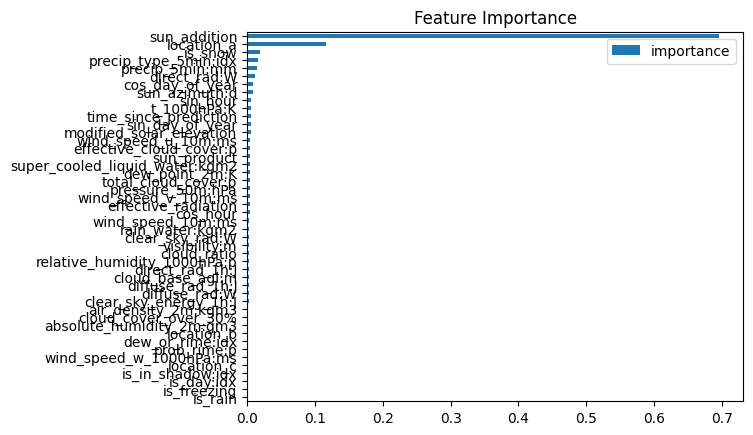

In [6]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=["importance"])

plt.figure(figsize=(200,100))
plt.tight_layout()
fi.sort_values("importance").plot(kind="barh", title="Feature Importance")
plt.show()

In [7]:
def multi_predict(x_values :pd.DataFrame, models) -> pd.DataFrame:
    """
    Function for predicting on multiple models and averaging the results
    """
    results = models[0].predict(x_values)
    for model in models[1:]:
        model: xgb.XGBRegressor
        prediction = model.predict(x_values)
        results += prediction
    
    results = results / len(models)

    return results


In [8]:
y_pred_val_obs_combined = multi_predict(X_val_obs_combined, reg_models)
y_pred_val_est_combined = multi_predict(X_val_est_combined, reg_models)

# Evaluate the model's performance using Mean Absolute Error (MAE) on the combined validation observed data
mae_obs_combined = mean_absolute_error(y_val_obs_combined, y_pred_val_obs_combined)
mae_est_combined = mean_absolute_error(y_val_est_combined, y_pred_val_est_combined)
print('MAE on validation observed data: ', mae_obs_combined)
print('MAE on validation estimated data: ', mae_est_combined)


MAE on validation observed data:  31.95232251497014
MAE on validation estimated data:  20.329621045427775


#Save Model


In [7]:


with open("reg_models.pkl", "wb") as file:
    pickle.dump(reg_models, file)

In [8]:
with open("reg_models.pkl", "rb") as file:
    loaded_reg_models = pickle.load(file)

In [9]:
# Predict on the cleaned validation set

y_predictions = multi_predict(x_test_whole, reg_models)



## Visualization  

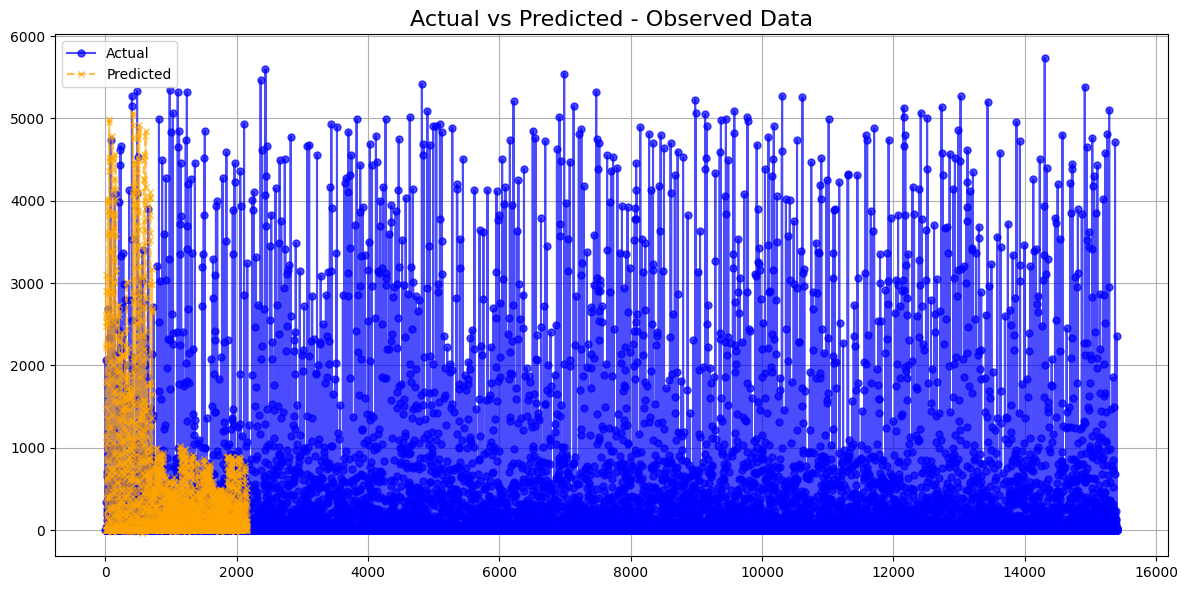

In [10]:

from matplotlib import pyplot as plt
import pandas as pd
# Set up the plotting area
plt.figure(figsize=(12, 6))

# Line plot of Actual values
plt.plot(y_val_obs_combined.reset_index(drop=True), label='Actual', linestyle='-', marker='o', markersize=5, alpha=0.7, color='blue')

# Line plot of Predicted values
plt.plot(pd.Series(y_predictions).reset_index(drop=True), label='Predicted', linestyle='--', marker='x', markersize=5, alpha=0.7, color='orange')

# Titles and labels
plt.title('Actual vs Predicted - Observed Data', fontsize=16)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Save model

In [11]:
from src.models.saving import save_predictions


save_predictions(y_predictions, 'xgboost random state 41')


   id  prediction
0   0    0.176354
1   1    0.101716
2   2    1.107534
3   3   66.248253
4   4  392.588440
